# NLP - finding fashion trends on Instagram posts


This is a notebook with my train of thought and analyses carried out to perform Engineering & Modeling of Instagram Data from fashion trending posts.

The document is divided in various sections: 
- Exploratory analysis
- Data cleaning
- Sentiment analysis
- Topic Modeling

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.pyplot import pie, axis, show
import seaborn as sns
import string
import spacy
from sklearn.decomposition import NMF
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from matplotlib.gridspec import GridSpec
from PIL import Image
from matplotlib.ticker import PercentFormatter
import requests
from io import BytesIO
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
data = pd.read_csv('/Users/GarimaSingh/Desktop/Garima/post_metrics_and_comments.csv')
top_appearance = pd.read_csv('/Users/GarimaSingh/Desktop/Garima/hashtag_top_appearances.csv')
post_metrics = pd.read_csv('/Users/GarimaSingh/Desktop/Garima/raw_post_metrics.csv')

# Exploratory analysis 
Checking the head of the data...

In [ ]:
data.head()

,post_url,username,date_posted,img_urls,caption,max_likes,max_comments,max_views,followers,following,concatenated_comments
0,https://www.instagram.com/p/B-y2oOeDpj2/,064_steady,2020-04-10,{https://finesse-instagram-post-images.s3-us-w...,온라인개학으로 아침마다 아이들에게 모닝콜을 해줄 수 있어서 행복합니다. 하하하하😭 ...,1019,38,NaN,8423,697,@_o9.02 가입하자 연재야😘|아고 ㅠㅠㅠㅠ 힘드실텐데 아자아자 화이팅입니다 !!...
1,https://www.instagram.com/p/B_B4e5qDtOU/,064_steady,2020-04-16,{https://finesse-instagram-post-images.s3-us-w...,2014. 04. 16. 우리 모두 웃을 수 있기를... more,1039,12,NaN,8423,697,@nam_bbs 정말요?🙌|옷입는 스타일 너무너무 멋있으세요 ☺️|코디 너무 좋아요...
2,https://www.instagram.com/p/B-3-Skoj2ub/,064_steady,2020-04-12,{https://finesse-instagram-post-images.s3-us-w...,내일이 월요일이니까 웃자😁... more,764,35,NaN,8423,697,❤️|헐 선생님....멋져요....♥️|워료일 쪼아~ 최고로 쪼아~|Very sum...
3,https://www.instagram.com/p/B_UhfCuDnJU/,064_steady,2020-04-23,{https://finesse-instagram-post-images.s3-us-w...,너무 배불러요 ㅠㅠㅠ... more,779,56,NaN,8423,697,ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ배불러졌다는게 너무 웃겨욬ㅋㅋㅋㅋㅋ|깔끔한 쓰앵님🤭👍🏿|😍😍😍😍❤...
4,https://www.instagram.com/p/B-6isIeD-0-/,064_steady,2020-04-13,{https://finesse-instagram-post-images.s3-us-w...,월요병 극복🥴,733,26,NaN,8423,697,극복 나이스👍🏻|@mndp404 시간은 결국 흐르니 ㅠㅠ|내일도 화요팅~!|@yeo...


Checking the other two datasets...

In [ ]:
top_appearance.head()

,post_url,days_in_hashtag_top_section
0,https://www.instagram.com/p/B-zJQlUI6uN/,38
1,https://www.instagram.com/p/B-cuVYrJncn/,36
2,https://www.instagram.com/p/B_CHJzXDeNF/,33
3,https://www.instagram.com/p/B-_07jGpiWT/,29
4,https://www.instagram.com/p/B-xB_snKjld/,29


In [ ]:
post_metrics.head()

,post_url,num_likes,num_comments,num_views,date_time_collected
0,https://www.instagram.com/p/B_PNBlGDTYQ/,647,15,NaN,2020-04-21 21:00:41
1,https://www.instagram.com/p/B-jWhHKjDsa/,925,105,NaN,2020-04-21 21:11:39
2,https://www.instagram.com/p/B-eNiazDOXp/,987,73,NaN,2020-04-21 21:11:42
3,https://www.instagram.com/p/B-oswDhDUB4/,960,73,NaN,2020-04-21 21:11:47
4,https://www.instagram.com/p/B-rM41AD62p/,715,67,NaN,2020-04-21 21:11:49


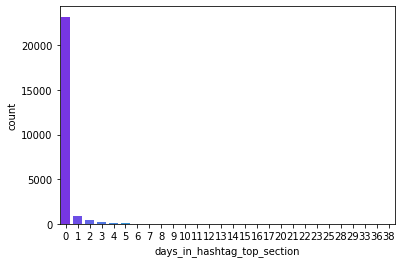

In [ ]:
sns.countplot(x='days_in_hashtag_top_section',data=top_appearance,palette='rainbow')


This is the histogram of the number of days in the dataset 'hashtag_top_apperance'. Most of the posts were not trending. Next, let's focus on those with at least 1 day on the top trending list.

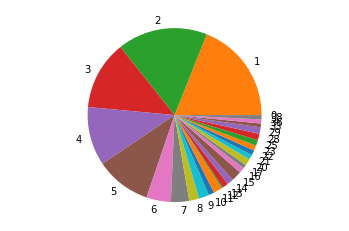

In [ ]:
sums = top_appearance.days_in_hashtag_top_section.groupby(top_appearance.days_in_hashtag_top_section).sum()
axis('equal');
pie(sums, labels=np.unique(top_appearance.days_in_hashtag_top_section));
show()

This is the number of posts by trending days. We can see that it is a pretty skewed distribution, so I am going to filter the top trending posts first (my threshold will be those that were longer than 1 day trending - this is arbitrary). My firt goal is getting a sense of the type of comments expressed by the people. After cleaning, I will also calculate a wordcloud to see if there is a common pattern trending within the trending posts. 

In [ ]:
# Concatenating caption and comments
data['important_text']= data['caption']+data['concatenated_comments']

# Before checking for nan and whitespace values, let's inspect the number of fields
data['post_url'].value_counts()

https://www.instagram.com/p/B_QAmWRAezn/    1
https://www.instagram.com/p/B-r80tZpa9C/    1
https://www.instagram.com/p/B_OqIU-HvOa/    1
https://www.instagram.com/p/B-py-o4nJcP/    1
https://www.instagram.com/p/B-4_88ZH_66/    1
                                           ..
https://www.instagram.com/p/B-iA557gPvk/    1
https://www.instagram.com/p/B-2WdMdjAuT/    1
https://www.instagram.com/p/B--r_SNpq0Y/    1
https://www.instagram.com/p/B_IX6N5Bhgc/    1
https://www.instagram.com/p/B_NZBB1J3N4/    1
Name: post_url, Length: 11637, dtype: int64

Let's inspect a wordcloud of this post

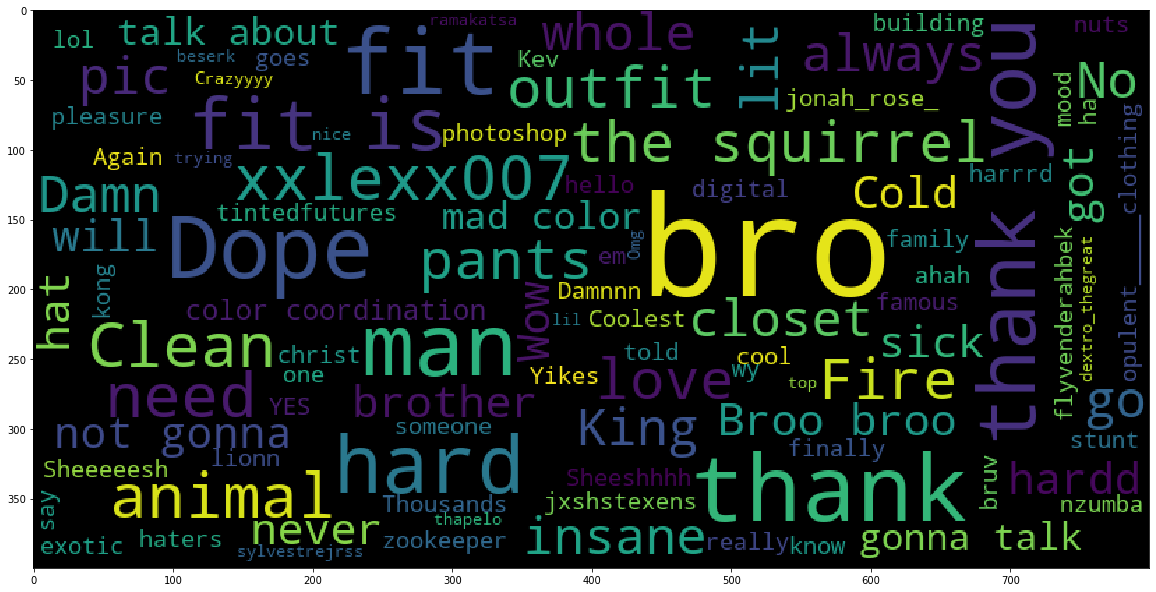

In [ ]:
wc = WordCloud(background_color='black',
                max_words = 100, max_font_size = 100, 
                random_state = 17, width=800, height=400)

plt.figure(figsize=(20, 12))
wc.generate(str(toppost))
plt.imshow(wc);

OK. I get a better idea of the type of comments people are making. For this specific post, I just see people talk about the pants and the hat. Most other comments refer to the squirrel, bro, or irrelevant terms to fashion topics.
At least it looks feasible, topic modelling and sentiment analysis will help to cluster categories.

I will continue with my analysis by extracting only posts with more than 1 day trending.

In [ ]:
print(top_appearance[top_appearance['days_in_hashtag_top_section']>1].count())

# There are 959 posts with more than 1 trending day. I am going to use 959 as the limit for posts with more than 1 day trending
tops_url = top_appearance.head(959).post_url.tolist()

# Filter our dataset with those tops
datatop = smalldata[smalldata.post_url.isin(tops_url)]
  
datatop.count()

post_url                       959
days_in_hashtag_top_section    959
dtype: int64


post_url          301
max_likes         301
max_comments      301
followers         301
following         301
important_text    301
days_trending     301
dtype: int64

MMMMMM... So only 301 of the top 959 URLS in the dataset top_appearance were found in post_metrics_and_comments. This may be an issue but for now I will continue, 301 posts to work with may be enough.

Number of likes correlates strongly with numbers of followers, which makes sense. 
Number of days trending is not significantly correlated with any other factor. I am not sure what metric they used exactly to calculate the trending days for a post but it cannot be recreated with these final metrics. It was probably based on sudden occurrences of likes and comments in short time periods.

# Data cleaning

In [ ]:
datatop.head(15)

,post_url,max_likes,max_comments,followers,following,important_text,days_trending
9,https://www.instagram.com/p/B_PMx6qjv89/,853,82,5541,745,Nothing but pose🔚구도 넘 머싯네요..🔥🔥👏👏|진짜 멋있다..🥰|해외무...,2.0
10,https://www.instagram.com/p/B_MmgRVDbKV/,846,71,5541,745,이젠 없으면 허전 hat🎓띵작템중 하나!!👍🏻👍🏻|띵작템중 하나!!👍🏻👍🏻|시그니쳐...,3.0
32,https://www.instagram.com/p/B_W9-hmj8ho/,4415,52,91500,446,All about luxury 🤷🏻‍♂️@bernickname merci bro 🙏...,4.0
105,https://www.instagram.com/p/B_VysJ0hUsI/,1905,17,205000,129,Be True 🌈... more🔥|🔥|Dope!🔥|Dope!🔥|Wow these c...,2.0
179,https://www.instagram.com/p/B_XyjgyH-Mk/,11688,66,165000,94,Fit For Those Upcoming Summer Nights 😎... more...,3.0
262,https://www.instagram.com/p/B_ajxQLg6ko/,666,116,5882,931,"time flies in quarantine, doesn’t it? 🌪Loving ...",3.0
263,https://www.instagram.com/p/B_VY_VuAR7H/,715,159,5882,931,today’s fit... morelove it|Aha i miss jeans 😂|...,2.0
353,https://www.instagram.com/p/B_agbM2nStj/,2150,76,33600,7495,Mood is: new loungewear 👼🏼 @misspap #misspap #...,3.0
362,https://www.instagram.com/p/B_VS6_1Hq_p/,1442,75,33600,7495,Stay at home summer 👼🏼 @misspap #misspap #miss...,2.0
410,https://www.instagram.com/p/B_O9Mm-qRod/,9048,75,110000,249,Left or Right ??? 🔥... more😍|Left🔥|Black on bl...,5.0


The text is pretty messy, with many non-ASCII characters and emojis. To clean the data, I will check to see if characters are in punctuations, getting rid of non-ASCII characters, and removing stopwords. I also wrote code to tokenize words into nouns, verbs, and adjective roots (discarding adverbs ) but decided not to in case that there were some trending words that would disappear. I decided to move forward with a more conservative approach.

In [ ]:
# this is required for the tokenization but in the end I did not use it
nlp = spacy.load("en_core_web_lg")

for s in datatop.index:    
    mytext = datatop['important_text'][s]      
    
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mytext if char not in string.punctuation]

    # Join the characters again to form the string.
    #nopunc = ''.join(nopunc)
    # Get rid of non ASCII characters
    printable = set(string.printable)
    nopunc = ''.join(filter(lambda x: x in printable, nopunc))
       
    # Now remove any stopwords
    nopunc = ' '.join([word for word in nopunc.split() if word.lower() not in stopwords.words('english')])
        
    # extract lemmas only for nouns, verbs, and adjectives
    #nouns = [token.lemma_ for token in nlp(nopunc) if token.pos_ == "NOUN"]
    #verbs = [token.lemma_ for token in nlp(nopunc) if token.pos_ == "VERB"]
    #adjs = [token.lemma_ for token in nlp(nopunc) if token.pos_ == "ADJ"] 
    
    datatop['important_text'][s] = nopunc
    #data100['important_text'][s] =" ".join(set(verbs+nouns+adjs))
datatop.head()   

,post_url,max_likes,max_comments,followers,following,important_text,days_trending,scores,coefficient,sentiment
9,https://www.instagram.com/p/B_PMx6qjv89/,853,82,5541,745,Nothing pose kicks combo insane outfit dude setup well put together Nothing pose prada shoes PRADA SHOES blazer shoes crazythe shoes crazy Classy Stacked Banger shot 1zsoo cvshedpauseshotspauseonlinenclgalleryclassyvisionthegallerystreetwearhighsnobietystyleculturfitslessisworesmartstreetwearcozystreetwearminimalhouse1minimalmovementhsstylestreetwearaddictedstreetcontentoutfitplacesimplefitscleanfitdailyfreshfitsmydailystreetsnobshotsbestfitsdailyoutfitsocietyfreshstreetfitspalacetalkfashionfuckeryminimalarchiveheadlessfits fit nice love shoes sick black fit Prada shoes Suit nice SickSick man Cozy sick Sick Steezy,2.0,"{'neg': 0.022, 'neu': 0.84, 'pos': 0.138, 'compound': 0.9682}",0.9682,pos
10,https://www.instagram.com/p/B_MmgRVDbKV/,846,71,5541,745,hat pants jacket cool know fabric itLovee fitLovee fit NiceNiceClean 2saturn leatherleatherCold fit Cold fit much flex 1zsoo cvshedpauseshotspauseonlinenclgalleryclassyvisionminimalhouse1lessisworesmartstreetwearcozystreetwearhighsnobietystylethegallerystreetwearculturfitssnobshotsmydailystreetstreetwearaddictedhsstyleoutfitplacepalacetalkbestfitsdailydailyfreshfitsfreshfitssimplefitsstreetcentraloutfitsocietyfashionfuckery Incredible fit Incredible fit Love Love Want shoes Leather Love fit Love fit Love fit Leather hatThose trousers shoes trousers shoes pants fire pants fire vibes killin mandope fit leather love leather love augustinasvasiliauskas especially diggin pantsaugustinasvasiliauskas especially diggin pantsCool leather look Cool leather look Cool leather look balenciaga Prada,3.0,"{'neg': 0.022, 'neu': 0.834, 'pos': 0.145, 'compound': 0.9786}",0.9786,pos
32,https://www.instagram.com/p/B_W9-hmj8ho/,4415,52,91500,446,luxury bernickname merci bro bernickname merci bro good DoirSick g hard pair Omg FireeCombo Dior GET ITLove combo Le jean vient la coupe lair grave sympa Le jean vient la coupe lair grave sympa Le jean vient la coupe lair grave sympa Le jean vient la coupe lair grave sympa Dior Le goal ces B23 Le goal ces B23 WantWantOeoeoe Big love hard brohard brobest wash jeans best wash jeans Fucking Vogue Love Love manUne valeur sure70svogue unreap virtualstylist mydailystreet fashionphotography instastreetwear snobshots adolescentcontent streetwearfashion streetstylist vintagestreetwear streetwearbrand fashiondesigner freshfits smartstreetwear streetwearinspo blancxivoire streetfashion streetwearaddict thefeargeneration cozystreetwear sumstreetwear homelessfits caminotvwannagettolondon thank u evilliveevillive thanks paulineguelen ahaha Big GBig GHes finna crease lilxmg kaffee3 asos kaffee3 asos kaffee3 asos grosyana grosyana 70svogue merci cest sympa luxury youAll luxury JadiorIcon,4.0,"{'neg': 0.071, 'neu': 0.851, 'pos': 0.078, 'compound': 0.508}",0.5080,pos
105,https://www.instagram.com/p/B_VysJ0hUsI/,1905,17,205000,129,True moreDopeDopeWow colours make summerWow colours make summerNaiceNaiceThanks fam repost Thanks fam repost Check dms bro Hola Precio tallasHola Precio tallasWhere buy shoes postWhere buy shoes postI got trainer AirMax AirMax1 AirMax90 Nike NikeAirMax NikeAir AM1 AM90 NiceKicks AirMax95 AirMax98 AM95 AirMax97 IGKicks FootBalla VaporMax AirMax270 AirMax720 OnFeet EverythingAirMax YesNike Streetwear SnobShots NikeSportswear Kicks SneakersAirMax AirMax1 AirMax90 Nike NikeAirMax NikeAir AM1 AM90 NiceKicks AirMax95 AirMax98 AM95 AirMax97 IGKicks FootBalla VaporMax AirMax270 AirMax720 OnFeet EverythingAirMax YesNike Streetwear SnobShots NikeSportswear Kicks SneakersBe True Shoutout carlescampama AirMaxKicks,2.0,"{'neg': 0.0, 'neu': 0.932, 'pos': 0.068, 'compound': 0.8284}",0.8284,pos
179,https://www.instagram.com/p/B_XyjgyH-Mk/,11688,66,165000,94,Fit Upcoming Summer Nights moreDope owayDope owayThose would look dope new reflective socks tholaphardlag laphardlag point kevincostinha trust bro

This is the wordcloud for the top 100 in the appearance list

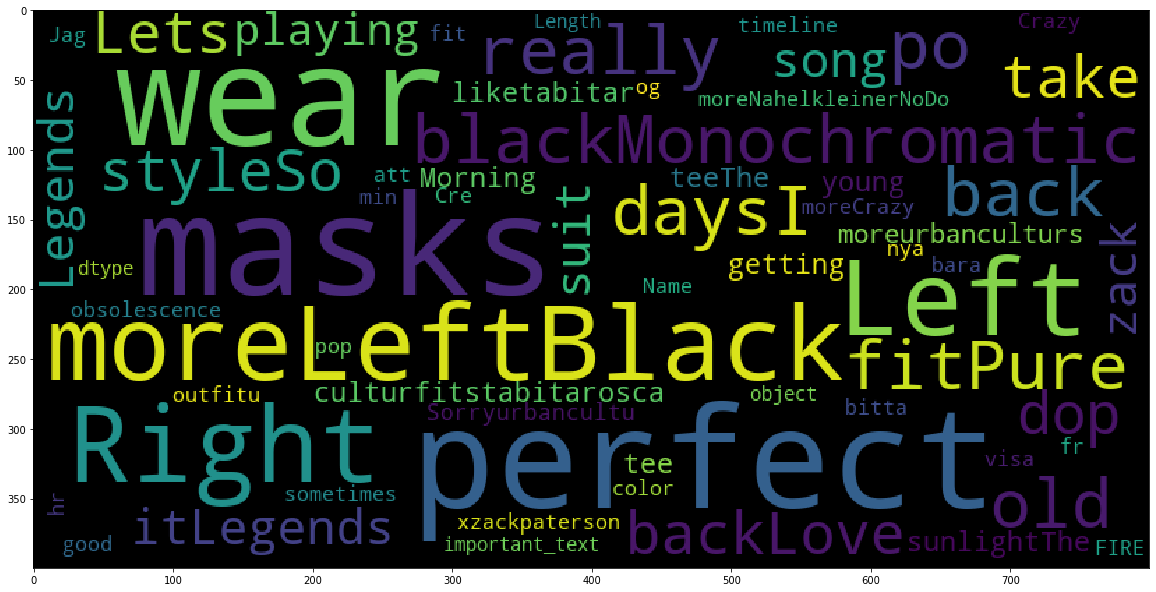

In [ ]:
wc = WordCloud(background_color='black',
                max_words = 100, max_font_size = 100, 
                random_state = 17, width=800, height=400)

plt.figure(figsize=(20, 12))
wc.generate(str(data100['important_text']))
plt.imshow(wc);

And this is for the top 300

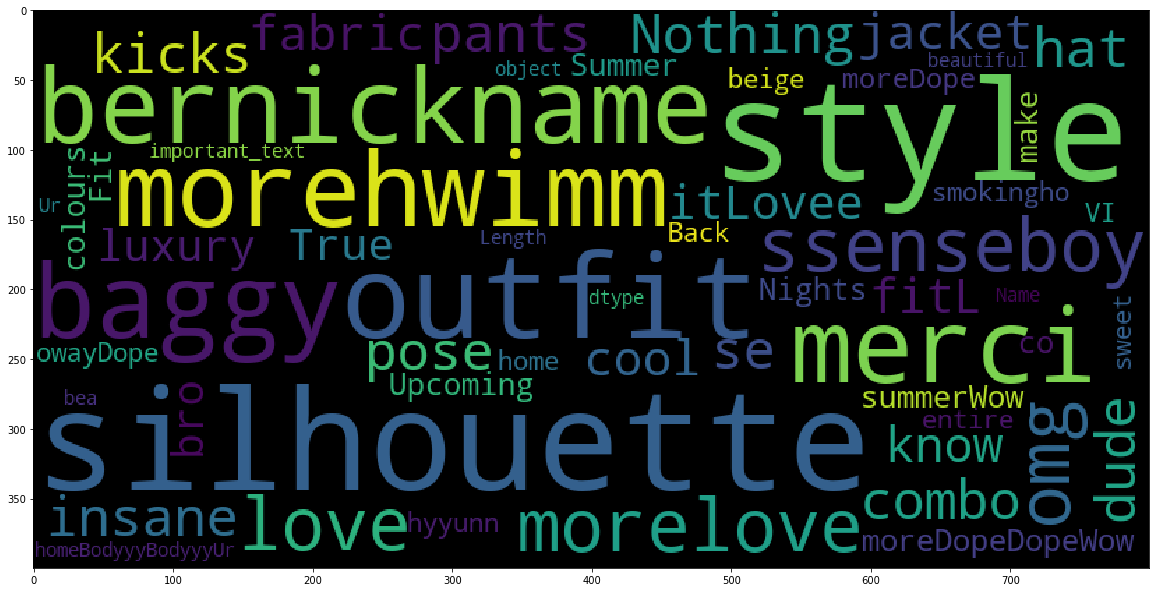

In [ ]:
wc = WordCloud(background_color='black',
                 max_font_size = 100, 
                random_state = 17, width=800, height=400)

plt.figure(figsize=(20, 12))
wc.generate(str(datatop['important_text']))
plt.imshow(wc);



# Sentiment analysis

To achieve this goal, I am going to use VADER, which is an NLTK module that provides sentiment scores based on words used ("totally" boosts a score, while "slightly" reduces it), on capitalization & punctuation ("FANTASTIC!!!" is stronger than "cool."), and negations (words like "isn't" and "doesn't" affect the outcome).


In [ ]:
sid = SentimentIntensityAnalyzer()
datatop['scores'] = datatop['important_text'].apply(lambda review: sid.polarity_scores(review))
# From -1 to 1
datatop['coefficient']  = datatop['scores'].apply(lambda score_dict: score_dict['compound'])
# category (positive/negative)
datatop['sentiment'] = datatop['coefficient'].apply(lambda c: 'pos' if c >=0 else 'neg')

datatop.head()

,post_url,max_likes,max_comments,followers,following,important_text,days_trending,scores,coefficient,sentiment
9,https://www.instagram.com/p/B_PMx6qjv89/,853,82,5541,745,Nothing pose kicks combo insane outfit dude setup well put together Nothing pose prada shoes PRADA SHOES blazer shoes crazythe shoes crazy Classy Stacked Banger shot 1zsoo cvshedpauseshotspauseonlinenclgalleryclassyvisionthegallerystreetwearhighsnobietystyleculturfitslessisworesmartstreetwearcozystreetwearminimalhouse1minimalmovementhsstylestreetwearaddictedstreetcontentoutfitplacesimplefitscleanfitdailyfreshfitsmydailystreetsnobshotsbestfitsdailyoutfitsocietyfreshstreetfitspalacetalkfashionfuckeryminimalarchiveheadlessfits fit nice love shoes sick black fit Prada shoes Suit nice SickSick man Cozy sick Sick Steezy,2.0,"{'neg': 0.221, 'neu': 0.487, 'pos': 0.292, 'compound': 0.5859}",0.5859,pos
10,https://www.instagram.com/p/B_MmgRVDbKV/,846,71,5541,745,hat pants jacket cool know fabric itLovee fitLovee fit NiceNiceClean 2saturn leatherleatherCold fit Cold fit much flex 1zsoo cvshedpauseshotspauseonlinenclgalleryclassyvisionminimalhouse1lessisworesmartstreetwearcozystreetwearhighsnobietystylethegallerystreetwearculturfitssnobshotsmydailystreetstreetwearaddictedhsstyleoutfitplacepalacetalkbestfitsdailydailyfreshfitsfreshfitssimplefitsstreetcentraloutfitsocietyfashionfuckery Incredible fit Incredible fit Love Love Want shoes Leather Love fit Love fit Love fit Leather hatThose trousers shoes trousers shoes pants fire pants fire vibes killin mandope fit leather love leather love augustinasvasiliauskas especially diggin pantsaugustinasvasiliauskas especially diggin pantsCool leather look Cool leather look Cool leather look balenciaga Prada,3.0,"{'neg': 0.043, 'neu': 0.42, 'pos': 0.537, 'compound': 0.9947}",0.9947,pos
32,https://www.instagram.com/p/B_W9-hmj8ho/,4415,52,91500,446,luxury bernickname merci bro bernickname merci bro good DoirSick g hard pair Omg FireeCombo Dior GET ITLove combo Le jean vient la coupe lair grave sympa Le jean vient la coupe lair grave sympa Le jean vient la coupe lair grave sympa Le jean vient la coupe lair grave sympa Dior Le goal ces B23 Le goal ces B23 WantWantOeoeoe Big love hard brohard brobest wash jeans best wash jeans Fucking Vogue Love Love manUne valeur sure70svogue unreap virtualstylist mydailystreet fashionphotography instastreetwear snobshots adolescentcontent streetwearfashion streetstylist vintagestreetwear streetwearbrand fashiondesigner freshfits smartstreetwear streetwearinspo blancxivoire streetfashion streetwearaddict thefeargeneration cozystreetwear sumstreetwear homelessfits caminotvwannagettolondon thank u evilliveevillive thanks paulineguelen ahaha Big GBig GHes finna crease lilxmg kaffee3 asos kaffee3 asos kaffee3 asos grosyana grosyana 70svogue merci cest sympa luxury youAll luxury JadiorIcon,4.0,"{'neg': 0.087, 'neu': 0.744, 'pos': 0.169, 'compound': 0.9473}",0.9473,pos
105,https://www.instagram.com/p/B_VysJ0hUsI/,1905,17,205000,129,True moreDopeDopeWow colours make summerWow colours make summerNaiceNaiceThanks fam repost Thanks fam repost Check dms bro Hola Precio tallasHola Precio tallasWhere buy shoes postWhere buy shoes postI got trainer AirMax AirMax1 AirMax90 Nike NikeAirMax NikeAir AM1 AM90 NiceKicks AirMax95 AirMax98 AM95 AirMax97 IGKicks FootBalla VaporMax AirMax270 AirMax720 OnFeet EverythingAirMax YesNike Streetwear SnobShots NikeSportswear Kicks SneakersAirMax AirMax1 AirMax90 Nike NikeAirMax NikeAir AM1 AM90 NiceKicks AirMax95 AirMax98 AM95 AirMax97 IGKicks FootBalla VaporMax AirMax270 AirMax720 OnFeet EverythingAirMax YesNike Streetwear SnobShots NikeSportswear Kicks SneakersBe True Shoutout carlescampama AirMaxKicks,2.0,"{'neg': 0.0, 'neu': 0.905, 'pos': 0.095, 'compound': 0.8176}",0.8176,pos
179,https://www.instagram.com/p/B_XyjgyH-Mk/,11688,66,165000,94,Fit Upcoming Summer Nights moreDope owayDope owayThose would look dope new reflective socks tholaphardlag laphardlag point kevincostinha trust br

The distribution of coefficients is not normal. In fact it looks bimodal. There is an incredibly large number of very positive posts. Next, I am going to generate wordclouds for the two categories (positive and negative) but being more restrictive, based on the distribution of coefficients. 

### Positive reviews
First, for positive I will only consider those posts that were extremely positive (>0.97)

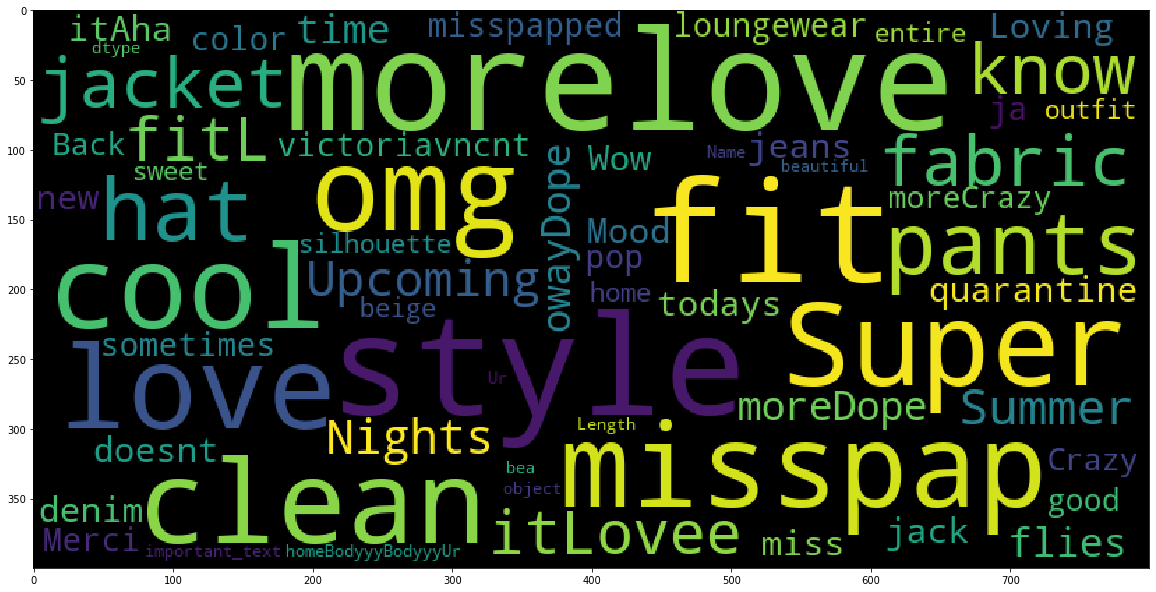

In [ ]:
plt.figure(figsize=(20, 12))
wc.generate(str(datatop[datatop['coefficient']>0.97]['important_text']))
plt.imshow(wc);

Now we see new words - loungewear, fabric, pants, jacket, hat, jeans...

### Negative reviews
Let's do the same for the negative words. For those, because the distribution looks bimodal, I will use a threshold of 0.5.

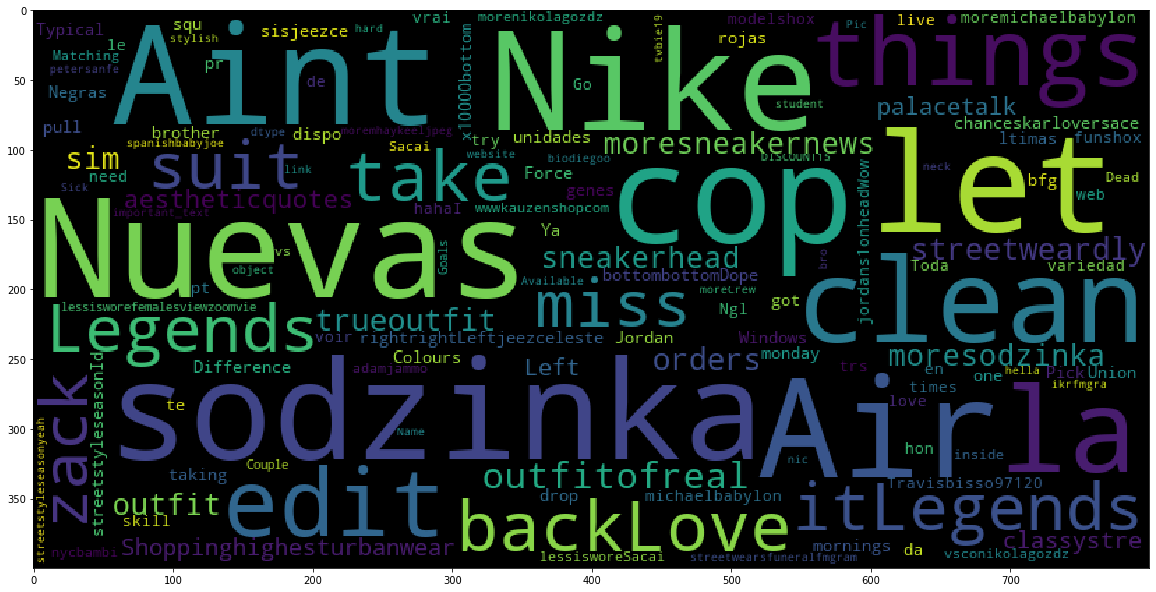

In [ ]:
plt.figure(figsize=(20, 12))
wc.generate(str(datatop[datatop['coefficient']<0.5]['important_text']))
plt.imshow(wc);

The very first think popping up is Nike Air. The new ('Nuevas') model is clearly disliked. Also interesting to see 'Cop' in this group...

# Topic modeling

It would be even more relevant to know whether there are different topics within the dataset of trending posts. I will use an approach using Non-negative Matrix Factorization. This requires to use TF-IDF Vectorization to create a vectorized document term matrix. 

In [ ]:
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english', ngram_range=(1, 2))
dtm = tfidf.fit_transform(datatop['important_text'])

### Non-negative Matrix Factorization
Using Scikit-Learn create an instance of NMF with 8 expected components. 8 is an arbitrary number.

In [ ]:
nmf_model = NMF(n_components=8,random_state=42)
nmf_model.fit(dtm)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=8, random_state=42, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [ ]:
for index,topic in enumerate(nmf_model.components_):
    print(f'TOP 15 Words for topic #{index+1}')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

TOP 15 Words for topic #1
['trading', 'love', 'brother', 'nice', 'mega', 'dm', 'good', 'man', 'shot', 'jeans', 'thank', 'style', 'great', 'look', 'bro']


TOP 15 Words for topic #2
['say', 'incredible', 'doesnt', 'human', 'burning', 'believe', 'like', 'love', 'comments', 'pic', 'dont', 'boy', 'getting', 'oh', 'year']


TOP 15 Words for topic #3
['want', 'cest', 'need', 'ones', 'tu', 'el', 'en', 'dont', 'like', 'pants', 'win', 'la', 'je', 'le', 'que']


TOP 15 Words for topic #4
['fucking', 'mal', 'hab', 'mir', 'und', 'das', 'ich', 'poor', 'jump', 'happened', 'bruh', 'wanna', 'wat', 'pissed', 'pretty']


TOP 15 Words for topic #5
['shorts', 'fit', 'merch', 'amen', 'dm', 'dope', 'sunday', 'bless', 'shirt', 'love', 'fam', 'bro', 'jesus', 'thanks', 'god']


TOP 15 Words for topic #6
['jacket', 'sick', 'cheers', 'black', 'thank', 'shot', 'outfit', 'dope', 'nice', 'man', 'love', 'clean', 'thanks', 'fit', 'bro']


TOP 15 Words for topic #7
['fait', 'die', 'friends', 'pick', 'account', 'need',

This looks slighthly more straight-forward. Topic 1 has some affectionate femenine words; topic 2 instead looks more masculine; topic 4 sounds religious; topic 5 looks related to streetwear outfit; topic 7 is French-related.